In [ ]:
!pip uninstall statsmodels -y



Uninstalling statsmodels-0.10.2:
  Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-97r50rwj
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-97r50rwj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+2.g54f7c05be-cp36-cp36m-linux_x86_64.whl size=10325309 sha256=f85b89dfee60eae00658c8d3834bb7660b4f9a357e87d0e1aa59b4e472c5571e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8qpee8n/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pywt

from itertools import islice
from collections import deque

from tensorflow.python.keras.layers import Input, Dense,RNN,LSTMCell
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.losses import mean_absolute_percentage_error,mae

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import statespace

from pandas.plotting import autocorrelation_plot

from datetime import datetime
from sklearn.metrics import classification_report,confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mae(A,F):
    return np.mean(np.abs(A -F))

def get_family(wave):
  if 'bior' in wave:
    return 'bior'
  elif 'coif' in wave:
    return 'coif'
  elif 'db' in wave:
    return 'db'
  elif 'dmey' in wave:
    return 'dmey'
  elif 'rbio' in wave:
    return 'rbio'
  elif 'sym' in wave:
    return 'sym'
  else:
    return 'haar'

def denoise(original,WAVELET):

  signal = original.values

  coeffs = pywt.wavedec(signal, WAVELET)
  coeffs[1:] = (pywt.threshold(detail,
                              value=0.5 * np.std(detail), 
                              mode="soft" ) for detail in coeffs[1:])
  reconstructed_signal = pywt.waverec(coeffs, WAVELET)
  return pd.Series(reconstructed_signal[:-1],index=original.index)


def window(seq, n=4):
  it = iter(seq)
  result = tuple(islice(it, n))
  if len(result) == n:
    yield np.array(result)
  for elem in it:
    result = result[1:] + (elem,)
    yield np.array(result)


In [ ]:
def percentage_scaler(signal,low=0,high=100):
  minV = np.min(signal)
  maxV = np.max(signal)
  denom = maxV - minV

  scaled_signal = low + ((signal - minV )* (high-low)) / denom 

  return round(scaled_signal)

def get_label(x):
  if x == 0.0:
    return 'ZERO'
  if x <= SCALE_UP_WATER_MARK:
    return 'NORMAL'
  else :
    return 'HIGH'

In [ ]:
SCALE_UP_WATER_MARK = 8

In [ ]:
df = pd.read_csv('winProxy.csv',parse_dates=True,index_col=0)
original = df.CPU
df['smooth_CPU'] = denoise(original,'db38')

df.diskwrite = df.diskwrite.shift(periods=1)
df.diskwrite = df.diskwrite.fillna(0)
#df[["CPU","diskwrite"]].tail()

df.IOBalance = df.IOBalance.shift(periods=1)
df.IOBalance = df.IOBalance.fillna(0)

df.diskwrite /= 100

In [ ]:
#pywt.wavelist(kind='discrete')
pass

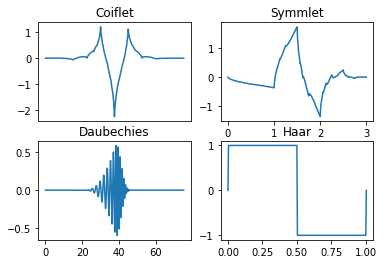

In [ ]:
fig,axs= plt.subplots(2,2)



#for ele in ['coif1','sym2','db2','haar']:
[phi,psi,x] = pywt.Wavelet('coif1').wavefun()
axs[0,0].plot(x,psi)
axs[0,0].set_title('Coiflet')
axs[0,0].set_xticks([])
[phi,psi,x] = pywt.Wavelet('sym2').wavefun()
axs[0,1].plot(x,psi)
axs[0,1].set_title('Symmlet')
[phi,psi,x] = pywt.Wavelet('db38').wavefun()
axs[1,0].plot(x,psi)
axs[1,0].set_title('Daubechies')
[phi,psi,x] = pywt.Wavelet('haar').wavefun()
axs[1,1].plot(x,psi)
axs[1,1].set_title('Haar')



plt.show()

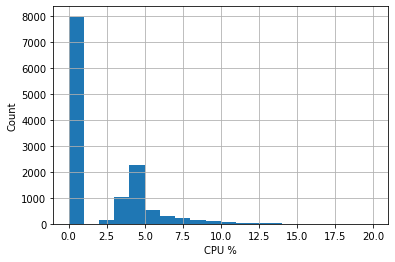

In [ ]:
#time_index = pd.date_range(start='2020-06-01T00:00:00',end='2020-07-16T00:00:00',freq='5T')
#df.index = time_index

ax = df.CPU.hist(bins=20,range=(0,20))
ax.set_xlabel('CPU %')
ax.set_ylabel('Count')
plt.show()

In [ ]:
#adfuller(df.CPU)
pass

In [ ]:
#df.CPU.plot()
pass

# RW

In [ ]:
train_size = round(len(df) * 0.8)

Y_test = original[train_size:].values

rw_forecast = ((original[train_size-1:]).shift(1)[1:]).values

In [ ]:
damp_forecast = np.minimum(SCALE_UP_WATER_MARK+0.01, rw_forecast)

In [ ]:
print("MAPE : ",mape(Y_test+1,rw_forecast+1))
print("SMAPE : ",smape(Y_test+1,rw_forecast+1))
print("MAE : ",mae(Y_test+1,rw_forecast+1))

MAPE :  6.67908647322508
SMAPE :  4.328813232318384
MAE :  0.3488425925925926


In [ ]:
print("MAPE : ",mape(Y_test+1,damp_forecast+1))
print("SMAPE : ",smape(Y_test+1,damp_forecast+1))
print("MAE : ",mae(Y_test+1,damp_forecast+1))

MAPE :  5.248347961165183
SMAPE :  4.080338640982604
MAE :  0.2833500514402006


In [ ]:
Y_test_labels = [get_label(x) for x in Y_test]
rw_test_labels = [get_label(x) for x in rw_forecast]

print(classification_report(Y_test_labels,rw_test_labels))
confusion_matrix(Y_test_labels,rw_test_labels)

              precision    recall  f1-score   support

        HIGH       0.30      0.30      0.30        27
      NORMAL       0.97      0.97      0.97       748
        ZERO       1.00      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.75      0.75      0.75      2592
weighted avg       0.98      0.98      0.98      2592



array([[   8,   13,    6],
       [  19,  726,    3],
       [   0,   10, 1807]])

In [ ]:
Y_test_labels = [get_label(x) for x in Y_test]
damp_labels = [get_label(x) for x in damp_forecast]

print(classification_report(Y_test_labels,damp_labels))
confusion_matrix(Y_test_labels,damp_labels)

              precision    recall  f1-score   support

        HIGH       0.30      0.30      0.30        27
      NORMAL       0.97      0.97      0.97       748
        ZERO       1.00      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.75      0.75      0.75      2592
weighted avg       0.98      0.98      0.98      2592



array([[   8,   13,    6],
       [  19,  726,    3],
       [   0,   10, 1807]])

# AR

In [ ]:
'''ma_forecast = []
training_endog = df.CPU[:train_size]
mod = sm.tsa.statespace.SARIMAX(df.CPU[:train_size], 
                          order=(4,0,0),freq='5T')
                          #exog = train.diskwrite.values  )
                          #seasonal_order=(0,1,6,288))
res = mod.fit()
ma_forecast.append(res.forecast(1)[0])'''

'''window_size = 4
MA = []
for row in window(original[train_size-4:-1],window_size):
    MA.append(row)

#print(MA[-1])
ma_forecast = pd.Series([np.mean(x) for x in MA])'''

pass

In [ ]:
ar_forecast = []
training_endog = df.CPU.values[:train_size]
mod = sm.tsa.statespace.SARIMAX(training_endog, 
                          order=(3,0,0))

res = mod.fit()
val = np.maximum(0,res.forecast()[0])
ar_forecast.append(round(val))


for i in range(0,len(df)-train_size):
  res = res.extend(df.CPU.values[train_size+i:train_size+i+1])
  val = np.maximum(0,res.forecast()[0])
  ar_forecast.append(round(val))

ar_forecast = np.array(ar_forecast)[:-1]

print("MAPE : ",mape(Y_test+1,ar_forecast+1))
print("SMAPE : ",smape(Y_test+1,ar_forecast+1))
print("MAE : ",mae(Y_test+1,ar_forecast+1))



In [ ]:
ar_test_labels = [get_label(x) for x in ar_forecast]

print(classification_report(Y_test_labels,ar_test_labels))
confusion_matrix(Y_test_labels,ar_test_labels)

              precision    recall  f1-score   support

        HIGH       0.33      0.22      0.27        27
     OPTIMAL       0.95      0.98      0.96       748
        ZERO       0.99      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.76      0.73      0.74      2592
weighted avg       0.97      0.98      0.97      2592



array([[   6,   15,    6],
       [  12,  733,    3],
       [   0,   27, 1790]])

# ANN

In [ ]:
time_window = 4
input_dims = 6
X = []
for row in window(df.CPU.values,time_window):
    X.append(row)

X = pd.DataFrame(X[:-1])
X.index = df.index[time_window:]
Y = df.CPU.iloc[time_window:]


#X['hour'] = df.index.hour[time_window:]
#X['weekday'] = df.index.weekday[time_window:]
X['IOBalance'] = df.IOBalance.to_numpy()[time_window:]
X['diskwrite'] = df.diskwrite.to_numpy()[time_window:]

In [ ]:
X_train = X.iloc[:train_size,:]
Y_train = Y[:train_size]

In [ ]:
#np.random.seed(42)
activation_fn = 'relu'

model = Sequential()
model.add(Dense(8, input_dim=input_dims,  activation=activation_fn))
model.add(Dense(4, activation=activation_fn))
model.add(Dense(1 ))

model.compile(loss='mae',
                optimizer='adam',
                metrics = ['mae']
              )

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=50, batch_size=32,
                    validation_split=0.2,shuffle=False,verbose=0)

In [ ]:
'''plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.show()'''

pass

In [ ]:
'''train_forecast = model.predict(X_train).flatten()
mae(Y_train,train_forecast)'''
pass

In [ ]:
X_test = X[train_size-4:]

ann_forecast = model.predict(X_test).flatten()
print("MAPE : ",mape(Y_test+1,ann_forecast+1))
print("SMAPE : ",smape(Y_test+1,ann_forecast+1))
print("MAE : ",mae(Y_test+1,ann_forecast+1))

MAPE :  5.588379823680037
SMAPE :  4.6308591259158565
MAE :  0.31621639873712293


In [ ]:
'''Watermark =8
print("Total usage under water mark", (Y_test < Watermark).sum())
print("Usage under water mark according to RW:",((Y_test < Watermark) & (rw_forecast < Watermark) ).sum())
print("Usage under water mark according to ANN:",((Y_test < Watermark) & (ann_forecast < Watermark) ).sum())
print("Usage under water mark according to AR:",((Y_test < Watermark) & (ar_forecast < Watermark) ).sum())

print("Total usage under water mark", (Y_test < Watermark).sum())
print("Usage not under water mark according to RW:",((Y_test < Watermark) & ~(rw_forecast < Watermark) ).sum())
print("Usage not under water mark according to ANN:",((Y_test < Watermark) & ~(ann_forecast < Watermark) ).sum())
print("Usage not under water mark according to AR:",((Y_test < Watermark) & ~(ar_forecast < Watermark) ).sum())'''
pass

In [ ]:
ann_test_labels = [get_label(round(x)) for x in ann_forecast]

print(classification_report(Y_test_labels,ann_test_labels))
confusion_matrix(Y_test_labels,ann_test_labels)

              precision    recall  f1-score   support

        HIGH       0.42      0.19      0.26        27
      NORMAL       0.97      0.99      0.98       748
        ZERO       1.00      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.79      0.72      0.74      2592
weighted avg       0.98      0.98      0.98      2592



array([[   5,   16,    6],
       [   7,  738,    3],
       [   0,   10, 1807]])

# Visualizations

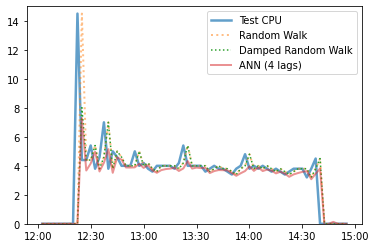

In [ ]:
test_index = original[train_size:].index

labs = ['12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
fig,ax = plt.subplots()
ax.set_xticklabels(labs)
ax.set_ylim(0,15)
#ax.set_yticklabels([0,5,10,15])

# imp: 0,50 200,250 300,350 750,800 870,900 1250,1300 1570,1620 1860,1930
start = 1860
end = 1930
_ = ax.plot(pd.Series(Y_test[start:end],index = test_index[start:end]),linewidth=2.5,label='Test CPU',alpha=0.7)
#_ = ax.axhline(y=SCALE_UP_WATER_MARK, linewidth=0.5,label='Watermark')
_ = ax.plot(pd.Series(rw_forecast[start:end],index = test_index[start:end]),linewidth=2,alpha = 0.5,linestyle='dotted',label = 'Random Walk')
#_ = ax.plot(pd.Series(arima_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = 'Exog ARIMA (3,1,6) ')
_ = ax.plot(pd.Series(damp_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dotted',label = 'Damped Random Walk')
_ = ax.plot(pd.Series(ann_forecast[start:end] ,index = test_index[start:end]),linewidth=2,alpha=0.5, label = 'ANN (4 lags)')

plt.legend()#loc='upper left'

plt.show()

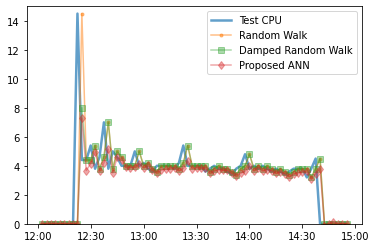

In [ ]:
test_index = original[train_size:].index

labs = ['12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
fig,ax = plt.subplots()
ax.set_xticklabels(labs)
ax.set_ylim(0,15)
start = 1860
end = 1930
#_ = ax.plot(pd.Series(Y_test[start:end],index = test_index[start:end]),linewidth=2.5,label='Test CPU',alpha=0.7)
_ = ax.plot(test_index[start:end],Y_test[start:end], label='Test CPU',linewidth=2.5,alpha=0.7)
_ = ax.plot(test_index[start:end],rw_forecast[start:end],'.-', label='Random Walk',alpha=0.5)
_ = ax.plot(test_index[start:end],damp_forecast[start:end],'s-', label='Damped Random Walk',alpha=0.4)
_ = ax.plot(test_index[start:end],ann_forecast[start:end],'d-', label='Proposed ANN',alpha=0.4)
plt.legend()#loc='upper left'

plt.show()

In [ ]:
np.range(ann_forecast)

0.005401234567901234

# Classification report

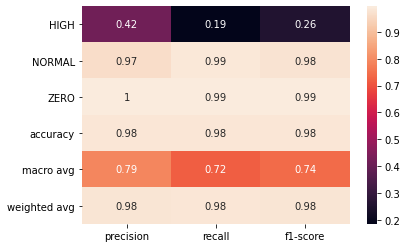

In [ ]:
ann_report = classification_report(Y_test_labels,ann_test_labels,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(ann_report).iloc[:-1, :].T, annot=True)

plt.show()

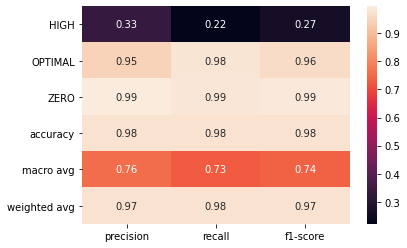

In [ ]:
ar_report = classification_report(Y_test_labels,ar_test_labels,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(ar_report).iloc[:-1, :].T, annot=True)

plt.show()

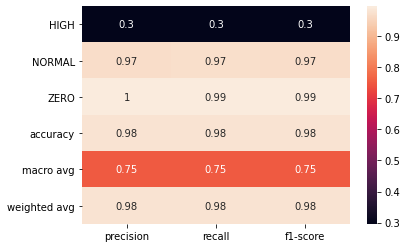

In [ ]:
rw_report = classification_report(Y_test_labels,rw_test_labels,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(rw_report).iloc[:-1, :].T, annot=True)

plt.show()

# CPU signal vs smoothed signal

In [ ]:
sample_start_date = '2020-06-18T11:30:00'
sample_end_date = '2020-06-18T17:00:00'


sample_set = (original.index > np.datetime64(sample_start_date)) & (original.index < np.datetime64(sample_end_date))
sample_index = original.index[sample_set]

In [ ]:
scaled_diskwrite = percentage_scaler(df.diskwrite)
scaled_diskread = percentage_scaler(df.diskread)

In [ ]:
original_sample = original[sample_set]
smoothed_sample = df['smooth_CPU'][sample_set]

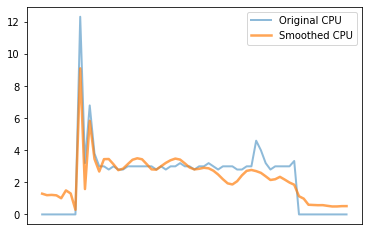

In [ ]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2,label='Original CPU',alpha=0.5)
_ = ax.plot(pd.Series(smoothed_sample ,index = sample_index),linewidth=2.5,alpha=0.7, label = 'Smoothed CPU')
ax.set_xticks([])
plt.legend(loc='upper right')

plt.show()

# CPU vs Diskwrites

In [ ]:
sample_writes = df.diskwrite[sample_set]

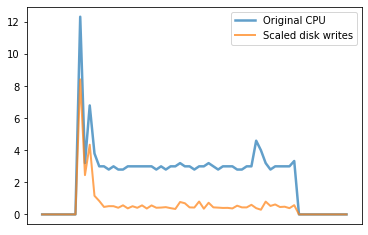

In [ ]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2.5,label='Original CPU',alpha=0.7)
_ = ax.plot(pd.Series(sample_writes ,index = sample_index),linewidth=2,alpha=0.7, label = 'Scaled disk writes')
ax.set_xticks([])

plt.legend(loc='upper right')

plt.show()

# CPU vs disk read

In [ ]:
sample_reads = df.diskread[sample_set]

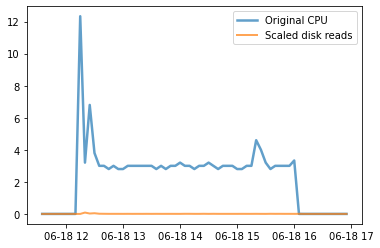

In [ ]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2.5,label='Original CPU',alpha=0.7)
_ = ax.plot(pd.Series(sample_writes ,index = sample_index),linewidth=2,alpha=0.7, label = 'Scaled disk reads')

plt.legend(loc='upper right')

plt.show()